# The goal is to create 2  functions:

# 1. Maps convolution to dot product.
# 2. Maps dot product to convolution.

All notation is consistent with the dpf.
It's quite essential for understanding what's going on here so please read it.

In [1]:
import numpy as np
from matplotlib.pyplot import imshow, figure
from matplotlib.pyplot import plot
from matplotlib.pyplot import show

np.set_printoptions(suppress=True,
   formatter={'float_kind':'{:0.2f}'.format})


np.seterr(all='raise')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

# Check the pdf from the repo to get the notation and generally what's going on. 

A helpful blogpost: https://www.johndcook.com/blog/tag/category-theory/

In [2]:
# essential functions

pixel = lambda local, kernel: (local * kernel).sum()
get_local = lambda image, i, j: image[i:i+5, j:j+5]

def conv(kernel, img):
    result = np.zeros_like(img)[4:, 4:]
    for i in range(0, result.shape[0]):
        for j in range(0, result.shape[1]):
            p =  pixel(get_local(img, i, j), kernel)
            result[i,j] = p
    return result

def dot(M, x):
    return M @ x

In [3]:
#useful stuff
def sqr(v):
    s = int(np.sqrt(v.shape[0] * v.shape[1]))
    return v.reshape((s,s))

def vec(m):
    return m.reshape(-1,1)

# this part is perhaps easier to understand 
# if you derive it yourself rather than read my solution
def fst_non_zero(x):
    assert x.shape[1] == 1
    j = 0
    for row in x:
        if row[0] != 0:
            return j
        j +=1
        
def row(x, summ):
    r =  np.zeros((1, x.shape[0]))
    j = fst_non_zero(x)
    r[0][j] = summ / x[j]
    return r

In [4]:
# matrix for a dot product equivalent to convlution with input imput sq(x) and output sq(y)
def matrix(x, y):
    return np.array([row(x,yy)[0] for yy in y])

# 1. Let's test if the matrix function works.

In [5]:
X = np.load("/home/const/convnet/X_test.npy").astype("float32")

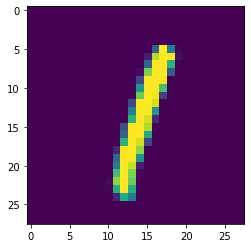

In [6]:
imshow(X[5])

In [7]:
x = vec(X[5])

In [8]:
# we have a kernel K
K = np.random.uniform(-2,2, (5,5))

# we want an equivalent matrix M
y = vec(conv(K, sqr(x)))
M = matrix(x, y)

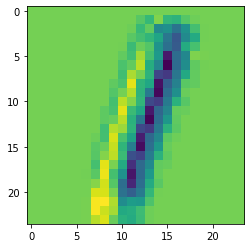

In [9]:
imshow(conv(K, sqr(x)))

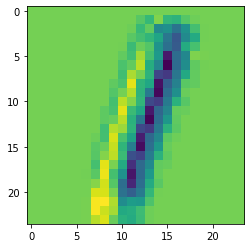

In [10]:
imshow(sqr(dot(M, x)))

In [11]:
np.allclose(conv(K, sqr(x)), sqr(dot(M, x)))

True

  # $sqr(dot(M, x)) = conv(K, sqr(x))$


# So we've got the conv to dot part: $K   ->   M$

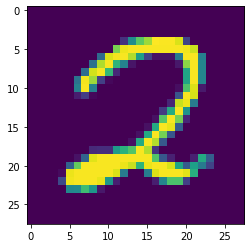

In [12]:
# Let's redefine parameters
#x = vec(X[35])
imshow(X[35])

In [13]:
# now M is known and we want K
# new M is close to the old one though
#M += np.random.uniform(-0.02, 0.02, (576, 784))
M += M*0.1
y = dot(M, x)

In [14]:
s = sqr(x)
z = sqr(y)

In [15]:
lambdas = []
for i in range(24):
    for j in range(24):
        lambdas.append(get_local(s, i, j).reshape(1,-1)[0])
        
lambdas = np.array(lambdas)
lambdas.shape

(576, 25)

In [16]:
K = sqr(np.linalg.lstsq(lambdas, y ,rcond=0)[0])

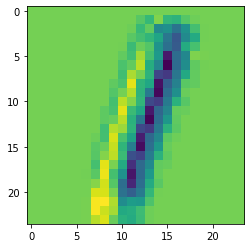

In [17]:
imshow(sqr(dot(M, x)))

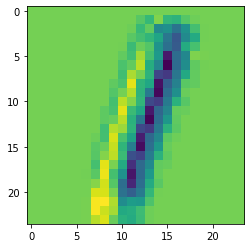

In [18]:
imshow(conv(K, sqr(x)))

In [19]:
np.allclose(conv(K, sqr(x)), sqr(dot(M, x)))

True

# $sqr(dot(M, x)) = conv(K, sqr(x))$
# Of course not all M have an equivalent K.
# I have an intuition that all the Ms we get from grad desc do have a K though.
# So hopefully we've got the dot to conv part: $M   -> K$
# Let's write a function for it:

In [39]:
def kernel(x, y):
    old_settings = np.seterr(all='warn', over='raise')

    s = sqr(x)
    z = sqr(y)
    lambdas = []
    for i in range(24):
        for j in range(24):
            lambdas.append(get_local(s, i, j).reshape(1,-1)[0])

    lambdas = np.array(lambdas)
    K = sqr(np.linalg.lstsq(lambdas, y ,rcond=None)[0])
    return K

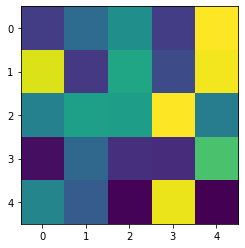

In [21]:
imshow(kernel(x, y))

# Let's try to learn an identity kernel from a random one.
https://karpathy.github.io/2019/04/25/recipe/
# Karpathy thinks if it overfits on one example it has to be not too bad.

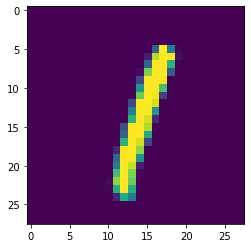

In [22]:
imshow(sqr(x))

In [23]:
def loss(p, q):
    return ((((p - q)**2).sum()) / p.shape[0])

In [24]:
2/576

0.003472222222222222

# IT FUCKING WORKS!

In [69]:
# x ->  m @ x = l -> loss(y_hat, l)

for j  in range(50):
    
    
    x = vec(X[j])/2



    identity_kernel = np.zeros((5,5))
    identity_kernel[0,0] = 1



 #   imshow(identity_kernel)
  #  show()
    y_hat = vec(conv(identity_kernel, sqr(x)))

    ran_k =  np.ones((5,5))
    #np.random.uniform(-1,1, (5,5)) #np.ones((5,5))

    first3_loss=[]
    last3_loss=[]

    for i in range(8):

        y = vec(conv(ran_k, sqr(x)))
        m = matrix(x, y)
        l = m @ x

        dloss_dl = 0.003472222222222222 * (l - y_hat)
        dl_dm = x

        dloss_dm = dloss_dl @ dl_dm.T
       # print(loss(y_hat, l))

        m = m - 0.0001 * dloss_dm

        l = m @ x
        #print(loss(y_hat, l))

        ran_k = kernel(x, l)
        if i in [0,1,2]:
            first3_loss.append(loss(y_hat, l))
        if i in [5,6,7]:
            last3_loss.append(loss(y_hat, l))



    #imshow(ran_k)
    #show()

    if sum(last3_loss) > sum(first3_loss):
        raise Exception(j)


KeyboardInterrupt: 

In [52]:
first3_loss

[1751587.6334525067, 1173159.9218440847, 785746.6949434051]

In [53]:
sum([1,2])

3

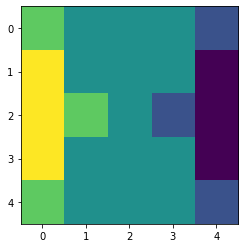

4140038.7167565045
5901625.273161821
5901625.334754151
8412767.032189488
8412767.08662071
11992399.649470434
11992399.687626757
17095165.99347266
17095165.789156515
24369159.17279602
24369159.13515756
34738236.832340874
34738236.607379384
49519356.97543455
49519357.04242974
70589844.4498811
70589843.87668867
100625823.85161665
100625823.711802
143442113.70456707
143442113.16988358
204476735.17950624
204476734.43990624
291481589.0150825
291481589.3293936
415507011.39225554
415507008.27966344
592305248.575129
592305244.8794892
844331138.3681161
844331138.7796828
1203594055.14051


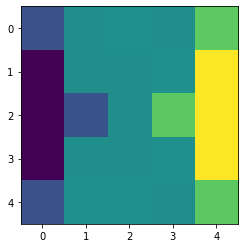

In [68]:
x = vec(X[1])
sobel_feldman_kernel  = np.array([[1, 0, 0, 0,-1],
                                  [2, 0, 0, 0,-2],
                                  [2, 1, 0,-1,-2],
                                  [2, 0, 0, 0,-2],
                                  [1, 0, 0, 0,-1]])


imshow(sobel_feldman_kernel)
show()
y_hat = vec(conv(sobel_feldman_kernel, sqr(x)))

ran_k = np.ones((5,5))  #np.random.uniform(-1,1, (5,5))



for i in range(16):

    y = vec(conv(ran_k, sqr(x)))
    m = matrix(x, y)
    l = m @ x

    
    dloss_dl = 0.003472222222222222 * (l - y_hat)
    dl_dm = x
    
    dloss_dm = dloss_dl @ dl_dm.T
    print(loss(y_hat, l))

    m = m - 0.0001 * dloss_dm
    
    l = m @ x
    print(loss(y_hat, l))

    ran_k = kernel(x, l)
    

imshow(ran_k)
show()

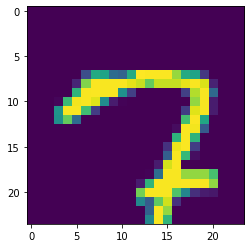

In [28]:
imshow(conv(identity_kernel, X[36]))

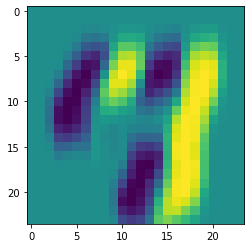

In [29]:
imshow(conv(sobel_feldman_kernel, sqr(x)))

# FUCK YEAH 
# IT CAN LEARN FUKING ANYTHING!!!

# let's check it on 2 different images just because I'm paranoid 

In [30]:
# generating a "dataset" of one example repeated a lot of times

data = [(x, y_hat) for _ in range(100)]


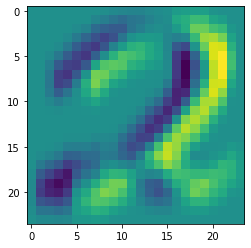

In [31]:
imshow(conv(sobel_feldman_kernel, X[35]))

In [32]:
X[8
 ]

array([[0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00,
        0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00,
        0.00, 0.00, 0.00, 0.00, 0.00, 0.00],
       [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00,
        0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00,
        0.00, 0.00, 0.00, 0.00, 0.00, 0.00],
       [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00,
        0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00,
        0.00, 0.00, 0.00, 0.00, 0.00, 0.00],
       [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00,
        0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00,
        0.00, 0.00, 0.00, 0.00, 0.00, 0.00],
       [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00,
        0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 17.00, 47.00, 47.00, 47.00,
        16.00, 129.00, 85.00, 47.00, 0.00, 0.00, 0.00],
       [0.00, 0.00, 0.00, 

In [33]:
old_settings = np.seterr(all='warn', over='raise')
np.int16(32000) * np.int16(3)

FloatingPointError: overflow encountered in short_scalars

In [84]:

data = [(vec(X[i]/2), vec(conv(sobel_feldman_kernel, X[i]/2))) for i in range(100)]


In [85]:
data[0][1].shape

(576, 1)

In [95]:
# x ->  m @ x = l -> loss(y_hat, l)
j = 0
ran_k =  np.ones((5,5))
for tup in data[:16]:
    x = tup[0]


    y_hat = tup[1]

  
    
    first3_loss=[]
    last3_loss=[]

    for i in range(8):

        y = vec(conv(ran_k, sqr(x)))
        m = matrix(x, y)
        l = m @ x

        dloss_dl = 0.003472222222222222 * (l - y_hat)
        dl_dm = x

        dloss_dm = dloss_dl @ dl_dm.T
       # print(loss(y_hat, l))

        m = m - 0.0001 * dloss_dm

        l = m @ x
        #print(loss(y_hat, l))

        ran_k = kernel(x, l)
        if i in [0,1,2]:
            first3_loss.append(loss(y_hat, l))
        if i in [13,14,15]:
            last3_loss.append(loss(y_hat, l))



    #imshow(ran_k)
    #show()

    if sum(last3_loss) > sum(first3_loss) and print(sum(last3_loss)/3) > 10000:        
        raise Exception(j)

    j+=1

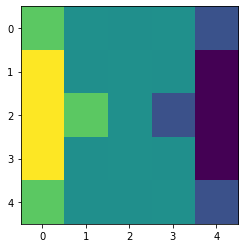

In [96]:
imshow(ran_k)

In [97]:
ran_k

array([[1.00, 0.00, -0.00, 0.00, -1.00],
       [2.00, -0.00, 0.00, -0.00, -2.00],
       [2.00, 1.00, 0.00, -1.00, -2.00],
       [2.00, -0.00, 0.00, -0.00, -2.00],
       [1.00, 0.00, -0.00, 0.00, -1.00]])

In [92]:
j

39

In [98]:
!pwd

/home/const/go/src/website/numpy_mnist/solving_MNIST
